In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis
import time
import scipy.stats
import copy
import statsmodels
from statsmodels.stats.anova import AnovaRM

root = '/usr/local/serenceslab/maggie/shapeDim/'
sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils, plot_utils, stats_utils, grid_utils

In [2]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 12)
figfolder = os.path.join(root, 'Analysis','figures')

In [3]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 10
subjects = np.arange(1,11)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [4]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
    

In [5]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_binary_withintask.npy')
print(save_filename)
print(time.ctime(os.path.getmtime(save_filename)))
dec = np.load(save_filename, allow_pickle=True).item()
dec.keys()
roi_names = dec['roi_names']
n_rois = len(roi_names)

/usr/local/serenceslab/maggie/shapeDim/Analysis/decoding_results/decode_binary_withintask.npy
Wed Aug 14 23:11:22 2024


In [6]:
dec['acc_bytask'].shape

(10, 8, 4, 3)

#### accuracy along each linear axis, in each task

In [7]:
n_tasks = 4

acc_fartrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

acc_midtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2,3,4]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        is_main_grid = l['is_main_grid']==1
        
        for ii in [0,1]:

            # actual category along this axis
            categ_actual = np.array(l['categ_task%d'%(ii+1)])
    
            dist_from_center = np.array(l['dist_from_bound%d'%(ii+1)]).round(1)
            
            # separate near (i.e. middle) and far trials
            # these are all in main grid, different distances from boundary.
            is_far = (dist_from_center==2.4) & is_main_grid
            is_middle = (dist_from_center==0.8) & is_main_grid
           
            is_correct = np.array(l['subject_correct'])
            
            for ri in range(n_rois):

                # switching categs here so that 1=coord<center, 2=coord>center
                categ_pred = 3-dec['preds_all'][si][ri][ti][ii].astype(int)
             
                # easy trials
                inds = is_far & is_correct
                
                acc_fartrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                # medium trials
                inds = is_middle & is_correct
                
                acc_midtrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                

In [8]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)
figfolder = os.path.join(root, 'Analysis','figures')

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/binary_acc_Far.pdf
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/binary_acc_Near.pdf


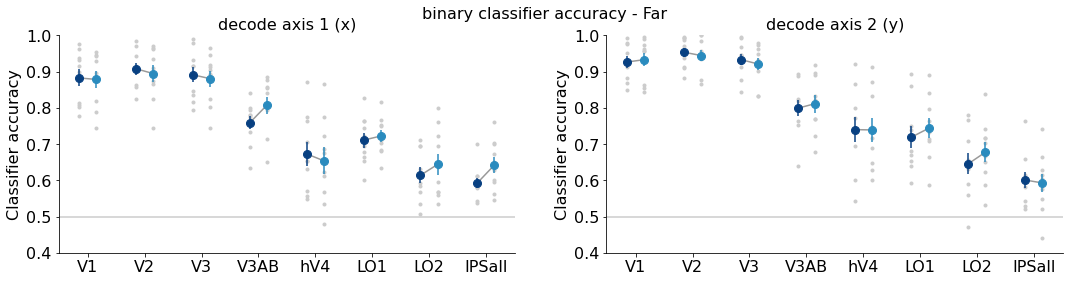

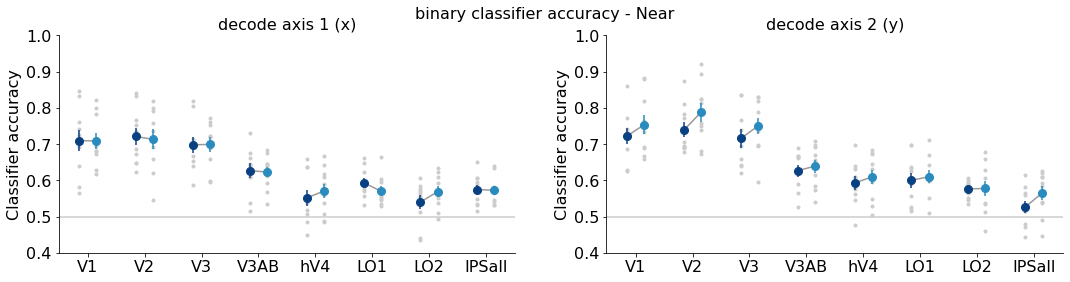

In [9]:
ti_plot = [0,1]

x_jitter = np.linspace(-0.15, 0.15, 2)

    
for avals, name in zip([acc_fartrials, acc_midtrials], \
                     ['Far','Near']):
    
    plt.figure(figsize=(18,4))
    
    # rvals = rvals[0:7]

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        ax = plt.subplot(1,2,ii+1)

        plt.axhline(1/2, color=[0.8, 0.8, 0.8])

        lh = []

        for ti in ti_plot:

            x_ticks = np.arange(n_rois) + x_jitter[ti]

            vals = avals[:,:,ti,ii]
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti], markersize=8, zorder=10)
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], \
                             linestyle='none', zorder=10)
            lh.append(h)
            
        for ri in range(n_rois):
            
            meanvals = np.mean(avals[:,ri,ti_plot,ii], axis=0)
            plt.plot([ri+x_jitter[0], ri+x_jitter[1]], meanvals,'-',color=[0.6, 0.6, 0.6])

            plt.plot(ri+x_jitter, avals[:,ri,ti_plot,ii].T, '.', color=[0.8, 0.8, 0.8], zorder=-10)
            
        plt.ylim([0.4, 1.0])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('Classifier accuracy')

        # plt.legend(lh,np.array(task_names)[ti_plot])

        plt.title('decode %s'%axis_name)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.suptitle('binary classifier accuracy - %s'%name)
    
    figname = os.path.join(figfolder, 'binary_acc_%s.pdf'%(name))
    print(figname)
    plt.savefig(figname)
# 


In [10]:
np.min(avals)

0.4344262295081967

In [11]:
np.max(acc_fartrials)

1.0

In [13]:

for xx, [avals, diffname] in enumerate(zip([acc_fartrials, acc_midtrials], \
                        ['Far','Near'])):

    
    vals = copy.deepcopy(avals[:,:,0:2,0:2])

    anova_result = stats_utils.rmanova_3way(vals, ['ROI','Task','Boundary'], \
                                            # do_shuffle=False)
                                           do_shuffle=True, n_iter=10000, rndseed = 423443+xx)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    tablename = os.path.join(figfolder, 'decodebinary_binary_acc_lin1vs2_rm_anova_%s.csv'%(diffname))
    
    print(tablename)
    anova_result.to_csv(tablename)

In [12]:
for diffname in ['Far','Near']:
    
    tablename = os.path.join(figfolder, 'decodebinary_binary_acc_lin1vs2_rm_anova_%s.csv'%(diffname))
    print(tablename)
    print(time.ctime(os.path.getmtime(tablename)))
    anova_result = pd.read_csv(tablename, index_col=0)
    print('\nAnova for accuracy, %s trials'%(diffname))
    
    print(anova_result)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_acc_lin1vs2_rm_anova_Far.csv
Thu Dec 12 08:49:58 2024

Anova for accuracy, Far trials
                      F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI                100.805491     7.0    63.0  0.0000           0.0000
Task                 2.914899     1.0     9.0  0.1219           0.1217
Boundary            40.458370     1.0     9.0  0.0001           0.0003
ROI:Task             2.610681     7.0    63.0  0.0197           0.0205
ROI:Boundary         3.695309     7.0    63.0  0.0021           0.0016
Task:Boundary        0.348788     1.0     9.0  0.5693           0.5659
ROI:Task:Boundary    1.544911     7.0    63.0  0.1687           0.1727
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_acc_lin1vs2_rm_anova_Near.csv
Thu Dec 12 09:00:49 2024

Anova for accuracy, Near trials
                     F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI                65.532968     7.0

In [11]:
for avals, diffname in zip([acc_fartrials, acc_midtrials], \
                        ['Far','Near']):

    for ii, axis_name in enumerate(['axis1','axis2']):

        vals = copy.deepcopy(avals[:,:,0:2,ii])

        anova_result = stats_utils.rmanova_2way(vals, ['ROI','Task'], \
                                                do_shuffle=False)
                                                # do_shuffle=True, n_iter=10000, rndseed = 243434+ii)

        
        anova_result['Pr > F'] = anova_result['Pr > F'].round(4)
    
        tablename = os.path.join(figfolder, 'decodebinary_binary_acc_rm_anova_%s_%s.csv'%(axis_name, diffname))
    
        print(tablename)
        anova_result.to_csv(tablename)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_acc_rm_anova_axis1_Far.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_acc_rm_anova_axis2_Far.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_acc_rm_anova_axis1_Near.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_acc_rm_anova_axis2_Near.csv


In [13]:
for diffname in ['Far','Near']:
    for axis_name in ['axis1','axis2']:

        tablename = os.path.join(figfolder, 'decodebinary_binary_acc_rm_anova_%s_%s.csv'%(axis_name, diffname))
        print(tablename)
        print(time.ctime(os.path.getmtime(tablename)))
        anova_result = pd.read_csv(tablename, index_col=0)
        print('\nAnova for %s accuracy, %s trials'%(axis_name, diffname))
        print(anova_result)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_acc_rm_anova_axis1_Far.csv
Thu Dec 12 19:56:41 2024

Anova for axis1 accuracy, Far trials
            F Value  Num DF  Den DF  Pr > F
ROI       74.824626     7.0    63.0  0.0000
Task       2.757855     1.0     9.0  0.1311
ROI:Task   3.678562     7.0    63.0  0.0022
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_acc_rm_anova_axis2_Far.csv
Thu Dec 12 19:56:41 2024

Anova for axis2 accuracy, Far trials
            F Value  Num DF  Den DF  Pr > F
ROI       75.711483     7.0    63.0  0.0000
Task       0.594379     1.0     9.0  0.4605
ROI:Task   0.935539     7.0    63.0  0.4858
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_acc_rm_anova_axis1_Near.csv
Thu Dec 12 19:56:41 2024

Anova for axis1 accuracy, Near trials
            F Value  Num DF  Den DF  Pr > F
ROI       42.383314     7.0    63.0  0.0000
Task       0.049948     1.0     9.0  0.8281
ROI:Task   0.754

In [14]:
for avals, diffname in zip([ acc_midtrials], \
                        ['Near']):

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        vals = copy.deepcopy(avals[:,:,0:2,ii])
        
        tstats_task = np.zeros((n_rois,),dtype=float)
        pvals_task = np.zeros((n_rois,),dtype=float)
        n_subs_samedir = np.zeros((n_rois,),dtype=int)

        rndseed = 8676786
        for rr in range(n_rois):

            t1_values = vals[:,rr,0]
            t2_values = vals[:,rr,1]
            p, t = stats_utils.paired_ttest_nonpar(t1_values, t2_values, \
                                                   # n_iter=2,
                                                   n_iter=10000, \
                                                   rndseed=rndseed+rr)    
            tstats_task[rr] = t
            pvals_task[rr] = p

            subj_diffs = t1_values - t2_values
            n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

        print('\n%s trials, %s'%(diffname, axis_name))
        task_df = pd.DataFrame({'t-stat for task 1 > task 2': tstats_task, \
                                'pvalue': pvals_task, \
                                'n_subs_indiv': n_subs_samedir}, \
                                  index=roi_names)
        print(task_df.round(3))


Near trials, axis 1 (x)
        t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                           0.049   0.975             7
V2                           0.383   0.709             7
V3                          -0.060   0.951             6
V3AB                         0.298   0.764             5
hV4                         -0.988   0.353             6
LO1                          1.243   0.304             7
LO2                         -2.011   0.101             7
IPSall                       0.109   0.916             5

Near trials, axis 2 (y)
        t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                          -2.145   0.064             7
V2                          -3.269   0.009             8
V3                          -2.804   0.024             7
V3AB                        -0.720   0.565             5
hV4                         -0.865   0.409             7
LO1                         -0.494   0.644             6
LO2                         -0.049   0